# Predicting Stock Price using XGBoost Classifier Model

This notebook can be used to predict the stock prices with sentiment scores and without. 

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
%matplotlib inline
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
import sys
sys.path.append(BASE_PATH+'/master_code_lib')
from stock_modelling_functions import data_preprocessing, data_train_test_split, window_data

### Loading Combined Dataframe

Load a combined dataframe with open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volume

combined_dataframe = ' '

In [3]:
# Read contains open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volume
df = pd.read_csv(combined_dataframe)

### Data Pre-processing

Pre-processing the data to get X and y.
If we want to include sentiment features we set the sentiment variable to 'True' else we set the sentiment variable to 'False'. 

In [4]:
df = data_preprocessing(df, sentiment=True)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,,,,,
2016-01-05,26.44,26.46,25.60,25.68,23.83,0.133635,1430.0,-0.024959
2016-01-06,25.14,25.59,24.97,25.17,23.36,0.072042,1949.0,-0.019723
2016-01-07,24.67,25.03,24.11,24.11,22.38,0.074369,2289.0,-0.041952
2016-01-08,24.64,24.78,24.19,24.24,22.50,0.051595,2235.0,0.005362
2016-01-11,24.74,24.76,24.33,24.63,22.86,0.019443,1222.0,0.016000


### Creating the Features `X` and Target `y` Data


 This function "window_data" accepts the column number for the features (X) and the target (y)
 
 It chunks the data up with a rolling window of Xt-n to predict Xt
 
 It returns a numpy array of X any y


In [8]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

### Split the data into training and testing data 
 Splitting the data based on 70% training set and 30% testing set ratio

In [9]:
X_train, X_test, y_train, y_test = data_train_test_split(X, y)

### Scaling Data with `MinMaxScaler`

We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.
Note that we scale both features and target sets.

In [11]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [12]:
# Create the XG Boost regressor instance
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [13]:
# Fit the model
model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Model Performance

In this section, we will evaluate the model using the test data. 

We will:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart


In [14]:
# Make some predictions
predicted = model.predict(X_test)

In [15]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.04125643265740012
R-squared : 0.9712877834737779


In [14]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [15]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2018-07-27,46.39,47.278915
2018-07-30,46.13,45.850224
2018-07-31,46.22,46.335148
2018-08-01,48.95,45.902985
2018-08-02,50.38,48.946964


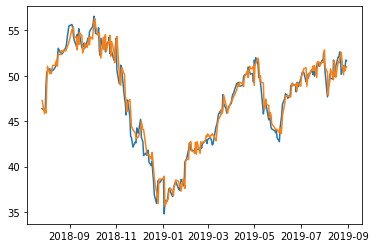

In [16]:
plt.plot(stocks['Real'], )
plt.plot(stocks['Predicted'])